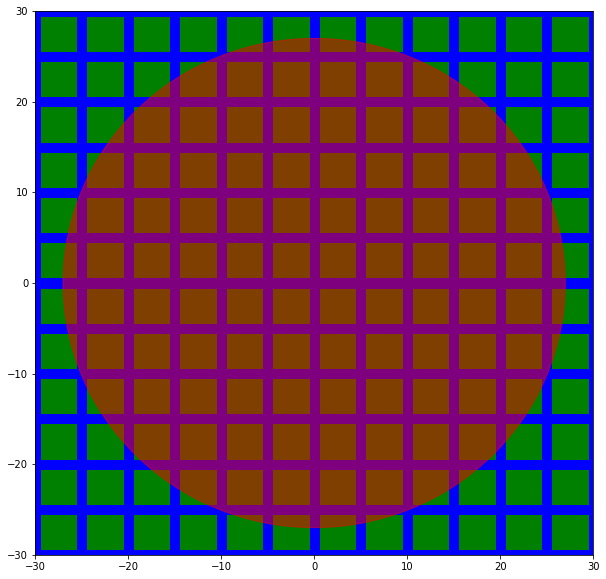

In [2]:
# To visualise the pattern of the catalyst and to find out their respective positions in a cross section of a pipe
# Note: Blue regions are the catalyst, red regions are the inner segment of the pipe (excludes pipe walls),
# green regions are voids
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
pos_cat_pos = []                             # Contains the catalyst positions that are possible in a quarter of a pipe

for a in range(12):
    for b in range(12):
        square = plt.Rectangle((5*b-30, 5*a-30), 5, 5, color='g')
        ax.add_artist(square)
        for i in range (10):
            small_square1 = plt.Rectangle((5*b-30+i/2, 5*a-30), 0.5, 0.5, color='b')
            small_square2 = plt.Rectangle((5*b-30+i/2, 5*a-30+4.5), 0.5, 0.5, color='b')
            
            if 5*b-30+i/2 >= 0 and 5*a-30 >= 0:
                pos_cat_pos.append((2*(5*b-30+i/2), 2*(5*a-30)))
            
            if 5*b-30+i/2 >= 0 and 5*a-30+4.5 >= 0:
                pos_cat_pos.append((2*(5*b-30+i/2), 2*(5*a-30+4.5)))
                
            ax.add_artist(small_square1)
            ax.add_artist(small_square2)
            
        for i in range (8):
            small_square3 = plt.Rectangle((5*b-30, 5*a-30+0.5+i/2), 0.5, 0.5, color='b')
            small_square4 = plt.Rectangle((5*b-30+4.5, 5*a-30+0.5+i/2), 0.5, 0.5, color='b')
            
            if 5*b-30 >= 0 and 5*a-30+0.5+i/2 >= 0:
                pos_cat_pos.append((2*(5*b-30), 2*(5*a-30+0.5+i/2)))
                
            if 5*b-30+4.5 >= 0 and 5*a-30+0.5+i/2 >= 0:
                pos_cat_pos.append((2*(5*b-30+4.5), 2*(5*a-30+0.5+i/2)))
            
            ax.add_artist(small_square3)
            ax.add_artist(small_square4)
        
circle = plt.Circle((0, 0), 27, color='r', alpha=0.5)
ax.add_artist(circle)

ax.set_xlim((-30, 30))
ax.set_ylim((-30, 30))

pos_cat_pos.sort()
plt.show()


Fraction of surface area occupied by catalyst:  0.3550755939524838
1
25.011466068761308
25.00558372593315
25.00588231388531
Delta T (Stop when < 0.001): 74.6179
2
25.022662472060688
25.011181504439435
25.01176436494694
Delta T (Stop when < 0.001): 39.1123
3
25.033614996789083
25.016791820072854
25.01764598953207
Delta T (Stop when < 0.001): 26.2095
4
25.044346237569016
25.022413268229286
25.023526959905723
Delta T (Stop when < 0.001): 18.7484
5
25.054876025886585
25.02804453661082
25.02940699106557
Delta T (Stop when < 0.001): 14.0123
6
25.065221799202902
25.033684391416557
25.035285748535216
Delta T (Stop when < 0.001): 11.3577
7
25.07539891873762
25.03933166717968
25.041162856632525
Delta T (Stop when < 0.001): 9.9589
8
25.085420943312442
25.044985259391353
25.047037906825267
Delta T (Stop when < 0.001): 8.7573
9
25.095299865538436
25.050644119228195
25.05291046588343
Delta T (Stop when < 0.001): 7.7409
10
25.105046315697734
25.05630724984121
25.05878008361782
Delta T (Stop when < 0.

FileNotFoundError: [Errno 2] No such file or directory: 'Surface_Data/0.11.png'

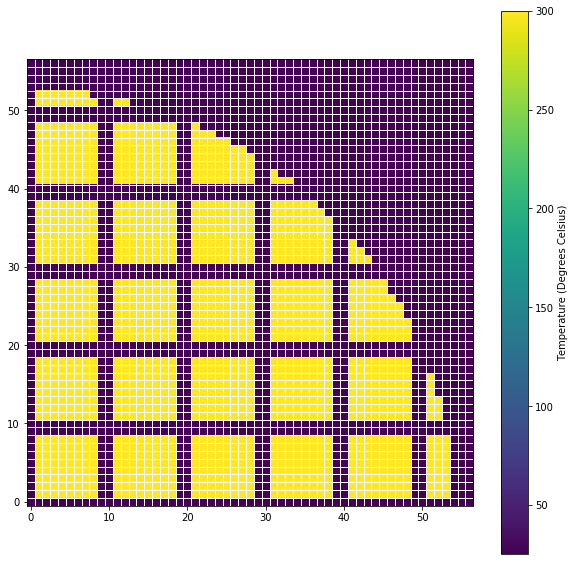

In [4]:
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import os
from decimal import Decimal

'''Input Parameters'''
OD = 56                     # Outer Diameter of Circle (mm)
ID = 54                     # Iner Diameter of Circle (mm)
dx = 0.5                    # Length of discretised square (mm) -- Do not change
L = 100                     # length of pipe (mm)

'''Functionalities'''
ratio_check = True           # Print surface area fraction occupied by catalyst.
equi_check = True            # Decides if need to check for thermal equilibrium.
calc_CO = False              # Set to true to calculate the extraction of CO, false to save computation time

'''Parameters for the talculation of temperature profiles'''
save_downstream_img = False # Whether to save downstream image. Ensure that a folder named Surface_data exists
save_loc = r""
choose_tab = 1              # Set to 0 to tabulate nothing, 1 for temperature profile of external surface, 2 for along catalyst
                            # and -1 for both

"Parameters for the calculation of CO extraction"
cat_work_temp = 0           # Set to 0 if assume a continuous curve. Else set to minimum temperature that is required before catalyst begins working (Kelvin)
nCO_array = []              # collection of emitted nCO emmited per second at different temps for the catalyst
init_nCO = 1.73*(10**(17))  # Initial number of CO molecules in one cross section
removed_nCO = 0             # number of CO removed in one cross section after passing through catalyst
target_nCO_rate = 1.17*(10**20) # Target carbon monoxide emission rate (molecules per second)

'''Time related parameters'''
dt = 0.01                   # time interval
step_limit = 10#000000000     # Maximum number of time_steps to take (Walltime)
t_filled = 0

'''Pipe related dictionarys and arrays'''
pipe_nodes = {}             # pipe_nodes contains the coordinates of pipe walls as the key and temp as values
pipe_inner = {}             # pipe_inner contains the coordinates of pipe interior as the key and temp as values
pipe_cat_2D = {}            # pipe_cat_2D contains the coordinates of pipe catalyst for 1 cross segment as key and temp as values
pipe_cat = {}               # 3D version of pipe_cat_2D
exposed_cat = []            # Contains the positions of pipe catalyst with an exposed surface to gas

'''Global Variables'''
ext_surf = []
cat_surf = []
timings = []
no_sq_catalyst = int(10/dx)
is_equi_reached = False
max_Tchange = 0
time_steps = 1

class steel_():
    def __init__(self):
        self.density = 8030*(10**-9)   # Density kg/mm^3
        self.tc = 16.3 * (10**-3)      # Thermal conductivity W/(Kmm)
        return
    
    def calc_shc(self, temp):          # Specific heat capacity J/(kgK)
        return 450 + 0.28*(temp-273)   # T is in degrees celsius

    
class catalyst_():
    def __init__(self):
        self.density = 2300*(10**-9)   # Density kg/mm^3
        self.tc = 2.5 * (10**-3)       # Thermal conductivity W/(Kmm)
        self.shc = 900                 # Specific heat capacity J/(kgK)
    
    
def calc_dt():
    global dt
    global t_filled
    # To calculate linear speed of the gas (in mm/s)
    pipe_inner_area = math.pi*((ID/2)**2)
    gas_speed = (5*10**6)/pipe_inner_area
    
    # dt = time taken for gas to travel one dx distance
    dt = dx/gas_speed
    
    # time steps before whole pipe is filled with exhaust gas
    t_filled = L/dx
    return


def time_step():
    global time_steps
    global dt
    global pipe
    global pipe_inner
    time_steps += 1 


def VisualiseXsect(a):
    grid = pipe[:, :,a] - 273
    fig, ax = plt.subplots(figsize = (10,10))
    my_img = ax.imshow(grid, origin = 'lower')
    ax.set_xticks(np.arange(grid.shape[1]-1)+0.5, minor=True)
    ax.set_yticks(np.arange(grid.shape[0]-1)+0.5,minor=True )
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', color = 'w', labelcolor = 'w')
    cbar = fig.colorbar(my_img, ax=ax)
    cbar.ax.set_ylabel('Temperature (Degrees Celsius)')   
    plt.savefig('Surface_Data/{0}.png'.format(time_steps*dt), dpi=300, bbox_inches='tight')
    plt.show()
    return


def Visualise3D(pipe):
    
    x,y,z = pipe.nonzero()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, zdir= 'z', c= pipe.flatten(), cmap = 'Reds')
    plt.show()
    return


def RasterQuad(a):
    global pipe
    global pipe_inner
    global pipe_nodes
    height = 0
    OR_max_Sq = int(OD/2/dx)
    
    for k in range (OR_max_Sq): 
        i=0
        if height <= ID/2:
            theta_IR = math.asin(height/(ID/2))
            curr_IR = ID/2*math.cos(theta_IR)
            no_sq_IR = round(curr_IR/dx)
            for i in range (no_sq_IR):
                if a > 0:                           # If not at the part where exhaust is coming from
                    pipe[i, k, a] = 573#25              # Temperature set to 25 degrees
                else: 
                    pipe[i, k, a] = 573             # If at the part where exhaust spawns, temp = 573K
                    pipe_inner.update({(i,k): 573})
                    
        theta_OR = math.asin(height/(OD/2))
        curr_OR = OD/2*math.cos(theta_OR)
        no_sq_Wall = round(curr_OR/dx) - no_sq_IR
        for j in range (no_sq_Wall):
            pipe[i+j, k, a] = 298                      # Set pipe walls to 25 degrees 
            pipe_nodes.update({(i+j,k, a): 298})
        height += dx
    return


def RasterCat():                                                
    global pipe
    global pipe_cat
    global pipe_cat_2D
    
    for i in range(len(pos_cat_pos)):
        try:
            _ = pipe_nodes[pos_cat_pos[i][0], pos_cat_pos[i][1], 0]
            continue
        
        except:
            pass
        
        try:
            _ = pipe_inner[pos_cat_pos[i][0], pos_cat_pos[i][1]]
            pipe_cat_2D.update({(pos_cat_pos[i][0], pos_cat_pos[i][1]):298})
        except:
            pass

    for _ in range(int(10/dx)):                               # Apply Raster cat on the last 1 cm of the pipe
        for j in pipe_cat_2D.keys():
            pipe[int(j[0]),int(j[1]),-(_+1)] = 298
            pipe_cat.update({(int(j[0]),int(j[1]),pipe.shape[2]-_-1):298})
            
            
    #print(len(pipe_cat.keys()))
    return
    

def calc_cat_dT(curr_pos, com_pos):
    global pipe_cat
    global pipe
    global pipe_nodes
    out_bounds = False
    tcc = 0
    
    if (com_pos[0] == -1 or com_pos[1] == -1 or com_pos[2] >= int(L/dx)):                                  
        out_bounds = True                                             
                                                                         
        if com_pos[2] >= int(L/dx):                                   
            return (298 - pipe_cat[curr_pos], out_bounds,2*(10**-6))  # Non-neighbour air at 25 degrees
        else:                                                           
            return (0, out_bounds, tcc)                               # By symmetry, assume it is the same material

    try:                                                                
        T_com = pipe_cat[com_pos]                                     # Check if it is a neighbour, catalyst     
        return (T_com - pipe_cat[curr_pos], out_bounds, tcc)
    except:
        try:                                                          # Check if it is a neighbour, Wall  
            T_com = pipe_nodes[com_pos]
            return (T_com - pipe_cat[curr_pos], out_bounds, tcc)
        except:                                                       # Otherwise must be a non-neighbour, air
            out_bounds = True
            T_com = pipe[com_pos]
            return (T_com - pipe_cat[curr_pos], out_bounds, 2*(10**-6))

def f2l_cat (material):
    global pipe_cat
    global pipe
    for r in pipe_cat.keys():                          # To calculate d2T_dx2, d2T_dy2, d2T_dz2
        out_bounds = np.zeros((6))
        dTs = np.zeros((6))
        tcc = np.zeros((6))
        dTs[0], out_bounds[0], tcc[0] = calc_cat_dT((r[0],r[1],r[2]),(r[0]-1,r[1],r[2]))   # minus dx
        dTs[1], out_bounds[1], tcc[1] = calc_cat_dT((r[0],r[1],r[2]),(r[0]+1,r[1],r[2]))   # plus dx
        dTs[2], out_bounds[2], tcc[2] = calc_cat_dT((r[0],r[1],r[2]),(r[0],r[1]-1,r[2]))   # minus dy
        dTs[3], out_bounds[3], tcc[3] = calc_cat_dT((r[0],r[1],r[2]),(r[0],r[1]+1,r[2]))   # plus dy
        dTs[4], out_bounds[4], tcc[4] = calc_cat_dT((r[0],r[1],r[2]),(r[0],r[1],r[2]-1))   # minus dz
        dTs[5], out_bounds[5], tcc[5] = calc_cat_dT((r[0],r[1],r[2]),(r[0],r[1],r[2]+1))   # plus dz
        #print(dTs, out_bounds, (r[0],r[1],r[2]))
        
        nc_dT = 0                                                                    # dT by neighbour contribution
        nnc_dT = 0                                                                   # dT caused by non-neighbour
        for i in range(out_bounds.shape[0]):
            if out_bounds[i] == 0:
                nc_dT += dTs[i]
            else:
                nnc_dT += tcc[i]*dTs[i]
        
        shc = material.shc
        nc = (dt/(material.density*shc*dx*dx))*material.tc*nc_dT
        nnc = (dt/(material.density*shc*dx))*nnc_dT
        pipe_cat[r] += nc + nnc  
    return

    
def calc_dT(curr_pos, com_pos):
    global pipe_nodes
    global pipe
    out_bounds = False
    tcc = 0
    
    if (com_pos[0] == -1 or com_pos[1] == -1 or com_pos[2] == -1
       or com_pos[2] >= int(L/dx)):                                  
        out_bounds = True                                             
                                                                         
        if com_pos[2] == - 1:                                           # Out_bounds will happen at the bottom right 
            return (573 - pipe_nodes[curr_pos], out_bounds,-1)          # and top left because the pipe is chopped up
        elif com_pos[2] >= int(L/dx):                                   # into a quarter. Since pipe is continuous, 
            return (298 - pipe_nodes[curr_pos], out_bounds,2*(10**-6))  # and due to symmetry, it is reasonable to assume
        else:                                                           # temp at compared position = temp at current position
            return (0, out_bounds, tcc)                                 # if out of the square box in the x and y directions
                                                                        # In the z direction, it will just be the air temp 25 
    try:                                                                # and 300 degrees since in contact with the manifold
        T_com = pipe_nodes[com_pos]                                     # and tcc between solids is infinite
        return (T_com - pipe_nodes[curr_pos], out_bounds, tcc)
    
    except:       
        
        try:
            T_com = pipe_cat[com_pos]
            return (T_com - pipe_nodes[curr_pos], out_bounds, tcc)
        except:                                                          
            T_com = pipe[com_pos]
            out_bounds = True
            return (T_com - pipe_nodes[curr_pos], out_bounds, 2*(10**-6))
    
def print_ratio(tot, cat):
    print("Fraction of surface area occupied by catalyst: ",cat/tot)
    
    
def f2l_pipe (material):
    global pipe
    global pipe_nodes
    for r in pipe_nodes.keys():                          # To calculate d2T_dx2, d2T_dy2, d2T_dz2
        out_bounds = np.zeros((6))
        tcc = np.zeros((6))
        dTs = np.zeros((6))
        dTs[0], out_bounds[0], tcc[0] = calc_dT((r[0],r[1],r[2]),(r[0]-1,r[1],r[2]))   # minus dx
        dTs[1], out_bounds[1], tcc[1] = calc_dT((r[0],r[1],r[2]),(r[0]+1,r[1],r[2]))   # plus dx
        dTs[2], out_bounds[2], tcc[2] = calc_dT((r[0],r[1],r[2]),(r[0],r[1]-1,r[2]))   # minus dy
        dTs[3], out_bounds[3], tcc[3] = calc_dT((r[0],r[1],r[2]),(r[0],r[1]+1,r[2]))   # plus dy
        dTs[4], out_bounds[4], tcc[4] = calc_dT((r[0],r[1],r[2]),(r[0],r[1],r[2]-1))   # minus dz
        dTs[5], out_bounds[5], tcc[5] = calc_dT((r[0],r[1],r[2]),(r[0],r[1],r[2]+1))   # plus dz
        #print(dTs, out_bounds, (r[0],r[1],r[2]))
        nc_dT = 0                                                                    # dT by neighbour contribution
        nnc_dT = 0                                                                   # dT caused by non-neighbour
        for i in range(out_bounds.shape[0]):
            if out_bounds[i] == 0:
                nc_dT += dTs[i]
            else:
                if tcc[i] == -1:
                    pipe_nodes[r] = 573
                    nnc_dT = -1
                    continue
                nnc_dT += tcc[i]*dTs[i]
        
        if nnc_dT == -1:
            continue
        shc = material.calc_shc(pipe[r[0], r[1], r[2]])
        nc = (dt/(material.density*shc*dx*dx))*material.tc*nc_dT
        nnc = (dt/(material.density*shc*dx))*nnc_dT
        #pipe[r[0], r[1], r[2]] += nc + nnc 
        pipe_nodes[r] += nc + nnc  
    return

def apply_temp_cat():
    global is_equi_reached
    global max_Tchange 

    for r in pipe_cat.keys():
        if pipe_cat[r] > pipe[r[0], r[1], r[2]] + 0.1*dt and pipe_cat[r] - pipe[r[0], r[1], r[2]] != 275:
            if pipe_cat[r] - pipe[r[0], r[1], r[2]] > max_Tchange:
                max_Tchange = pipe_cat[r] - pipe[r[0], r[1], r[2]]
            is_equi_reached = False
        pipe[r[0], r[1], r[2]] = pipe_cat[r]
    return

def apply_temp():
    global is_equi_reached
    global max_Tchange 
    for r in pipe_nodes.keys():
        if pipe_nodes[r] > pipe[r[0], r[1], r[2]] + 0.1*dt and pipe_nodes[r] - pipe[r[0], r[1], r[2]] != 275:
            if pipe_nodes[r] - pipe[r[0], r[1], r[2]] > max_Tchange:
                max_Tchange = pipe_nodes[r] - pipe[r[0], r[1], r[2]]
            is_equi_reached = False
        pipe[r[0], r[1], r[2]] = pipe_nodes[r]
    return


def tabulate_data(data_type): # Tabulate temperature of external surface
    global timings
    global ext_surf
    global cat_surf
    
    if data_type == 3:
        curr_nCO = init_nCO - removed_nCO
        nCO_array.append(curr_nCO/0.0000148)
        return
    
    timings.append(dt*(time_steps-1))
    
    if data_type == 1:
        ext_surf.append(pipe[54,1,:]-273)          # -273 to print the answer in degrees celsius
         
    elif data_type == 2:
        cat_surf.append(pipe[0,4,-20:]-273)        # -273 to print the answer in degrees celsius
        
    elif data_type == -1:
        ext_surf.append(pipe[54,1,:]-273)          # -273 to print the answer in degrees celsius
        cat_surf.append(pipe[0,4,-20:]-273)        # -273 to print the answer in degrees celsius
    
    return


def check_cat(check_pos): # Only return 1 if check_pos is not a wall, not a catalyst
    
    if check_pos[0] == -1 or check_pos[1] == -1:        # If at the edges, by symmetry,
        return 0                                        # the compared element is also a catalyst node
    
    try:
        _ = pipe_cat[check_pos]                         # To check if compared element is a catalyst node
        return 0
    
    except: 
        try:
            _ = pipe_nodes[check_pos]                   # To check if compared element is a wall
            return 0
        
        except:
            return 1


def count_cat_area(): # Area of catalyst exposed to gas in 1 cross section
    
    for r in pipe_cat.keys():
        is_cat = np.zeros((4))
        
        is_cat[0] = check_cat((r[0] + 1, r[1], r[2]))
        is_cat[1] = check_cat((r[0] - 1, r[1], r[2]))
        is_cat[2] = check_cat((r[0], r[1] + 1, r[2]))
        is_cat[3] = check_cat((r[0], r[1] - 1, r[2]))
        
        if np.sum(is_cat) == 1:
            exposed_cat.append(r)
    
    return


def extract_CO():
    global removed_nCO
    
    removed_nCO = 0
    for r in exposed_cat:
        if pipe[r[0],r[1],r[2]] >= cat_work_temp:
            removed_nCO += 1.48 * (10**16)* np.exp(-28500/(8.314*pipe[r[0],r[1],r[2]]))     

    removed_nCO = removed_nCO*4                                                # Account for symmetry
    print("Total number of mollecules of CO removed in 1 segment: {:.2E}".format(Decimal(removed_nCO)))
    return


def plot_emissions():

    fig, ax = plt.subplots()
    ax.plot(timings, nCO_array)
    plt.xlabel('Time(s)')
    plt.ylabel('N(CO) emitted per second (/s)') 
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    plt.show()
    return


def plot_graph(data_type):   # Tabulate temperature profile along external surface over time
    
    if data_type == 1 or data_type == -1:
        x = np.zeros((int(L/dx)*len(timings)))
        t = np.zeros((int(L/dx)*len(timings)))
        for i in range(len(timings)):
            x[i*int(L/dx):(i+1)*int(L/dx)] = np.divide(np.arange(int(L/dx)), 2)
            _ = np.zeros((int(L/dx)))
            _.fill(timings[i])
            t[i*int(L/dx):(i+1)*int(L/dx)] = _.copy()
        z = np.asarray(ext_surf).flatten()
        
        fig, ax = plt.subplots(figsize = (10,10))
        plt.xlabel("Position along external surface of pipe (mm)")
        plt.ylabel("Time (s)")
        plot = ax.scatter(x, t, c = z, cmap = 'viridis', s = 5, alpha = 0.7)
        cbar = fig.colorbar(plot, ax=ax)
        cbar.ax.set_ylabel('Temperature (Degrees Celsius)')      
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        plt.margins(0)
        plt.show()
    
    if data_type == 2 or data_type == -1:
        x = np.zeros((no_sq_catalyst*len(timings)))
        t = np.zeros((no_sq_catalyst*len(timings)))

        for i in range(len(timings)):
            x[i*no_sq_catalyst:(i+1)*no_sq_catalyst] = np.divide(np.arange(no_sq_catalyst), 2)
            _ = np.zeros((no_sq_catalyst))
            
            _.fill(timings[i])
            t[i*no_sq_catalyst:(i+1)*no_sq_catalyst] = _.copy()
        z = np.asarray(cat_surf).flatten()
        
        fig, ax = plt.subplots(figsize = (10,10))
        plt.xlabel("Position along length of catalyst (mm)")
        plt.ylabel("Time (s)")
        plot = ax.scatter(x, t, c = z, cmap = 'viridis', s = 5, alpha = 0.7)
        cbar = fig.colorbar(plot, ax=ax)
        cbar.ax.set_ylabel('Temperature (Degrees Celsius)')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        plt.show()
    return    

t_cat_start = 0
t_cat_end = 0

def main():
    global choose_tab
    global is_equi_reached
    global max_Tchange

    #calc_dt()
    steel = steel_()
    catalyst = catalyst_()

    for i in range(step_limit):
        print(time_steps)
        
        if time_steps % 50 == 0 and save_downstream_img:
            VisualiseXsect(-1)
        
        if choose_tab != 0:
            tabulate_data(choose_tab)
            
        f2l_pipe(steel)
        f2l_cat(catalyst)
        apply_temp_cat()
        apply_temp()
        print(pipe[0,4,180] - 273)
        print(pipe[0,4,-1] -273)
        print(pipe[0,4,190] -273)
        time_step()
          
        if calc_CO:
            extract_CO()
            tabulate_data(3)
            if nCO_array[-1] <= target_nCO_rate:
                break
                
        if equi_check == True:                  # If the break condition is when equilibrium is reached
            print("Delta T (Stop when < 0.001):", round(max_Tchange, 4))
            if is_equi_reached == True:         # Break if condition is met
                break
            is_equi_reached = True              # Reset to true, any failure to meet condition makes it false
            max_Tchange = 0
            
    VisualiseXsect(-1)
    plot_graph(choose_tab)
    
    if calc_CO:
        plot_emissions()
    return

gridWid = int(OD/dx/2 + 1)                      # To make a quarter cross section of the hollow pipe
grid = np.zeros((gridWid, gridWid))             # Make at least 1 more grid square than the outer radius of the pipe
pipe = np.zeros((gridWid, gridWid, int(L/dx)))
pipe.fill(298)

for a in range(int(L/dx)):                      # To construct the 3D pipe array (Quarter of it)
    RasterQuad(a)

RasterCat()
count_cat_area()

if ratio_check:
    print_ratio(len(pipe_inner.keys()), len(pipe_cat_2D.keys())) 

main() 